In [1]:
# Standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [2]:
import sklearn

sklearn.set_config(display='diagram')

### Contents:

- [Import Data](#Read-in-Data)
- [NB TfidfVectorizer](#NB-TfidfVectorizer)
- [NB Tfidf No Stop Words](#NB-Tfidf-No-Stop-Words)
- [Multinomial NB](#Multinomial-NB-CV)
- [SVC Tfidf](#SVC-Tfidf)
- [Optimal SVC](#Optimal-SVC)
- [Optimal SVC Word Counts and Weights](#Optimal-SVC-Word-Counts-and-Weights)
- [Pickle](#Pickle)

## Read in Data

In [3]:
# read in scraped data store in df
final_both = pd.read_csv('./data/scraped_sr.csv',index_col=0)

In [4]:
# Make our X and y
# X is post title
# y is which subreddit the post belongs to
X = final_both['title']

y = final_both['subreddit']

In [5]:
# take a look at the target values
y.value_counts()

wallstreetbets     4000
MachineLearning    4000
Name: subreddit, dtype: int64

In [6]:
# y = y.map({'MachineLearning':0,'wallstreetbets':1})

In [7]:
y.value_counts()

wallstreetbets     4000
MachineLearning    4000
Name: subreddit, dtype: int64

In [8]:
# split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=.3)

## NB TfidfVectorizer

First, I need to set up a pipeline with TfidfVectorizer and MultinomialNB. Later on I will remove stop words and compare performance.

In [9]:
# create a pipeline with tfidf and naive bayes

pipe = make_pipeline(TfidfVectorizer(),MultinomialNB())

pipe.fit(X_train,y_train)

pipe.score(X_test,y_test)

0.94875

In [10]:
# helpful for identifying hyperparameters that can be gridsearched over

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'multinomialnb', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'multinomialnb__alpha', 'multinomialnb__class_prior', 'multinomialnb__fit_prior'])

In [11]:
# params to gridsearch over

params = {
    'tfidfvectorizer__max_features': range(3000,6001,250),
    'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)],
#     'multinomialnb__alpha':[.01,.1,1,2]
}

gs = GridSearchCV(pipe,params)

In [12]:
# fit model to training data and get best params

gs.fit(X_train,y_train)

gs.best_params_

{'tfidfvectorizer__max_features': 6000, 'tfidfvectorizer__ngram_range': (1, 1)}

In [13]:
# score model on train set

gs.score(X_train,y_train)

0.9769642857142857

In [14]:
# score model on test set

gs.score(X_test,y_test)

0.9479166666666666

In [15]:
# best estimator best score

gs.best_score_

0.950357142857143

As we can see the most frequent words are common stop words that we should remove.

Now, let's set up a pipeline removing stop words with TfidfVectorizer and MultiNB.

## NB Tfidf No Stop Words

In [16]:
# set up pipeline removing stopwords

pipe_sw = make_pipeline(TfidfVectorizer(stop_words='english'),MultinomialNB())

pipe_sw.fit(X_train,y_train)

pipe_sw.score(X_test,y_test)

0.94375

In [17]:
pipe_sw.score(X_train,y_train)

0.9830357142857142

It appears that this model is overfitting a bit to the training data. In addition to this is it performing worse than our same pipeline set up with stopwords. Let's set up a gridsearch to search over hyperparameters in hopes of further improving model performance and reduce overfitting.

In [18]:
params = {
    'tfidfvectorizer__max_features': range(1000,4001,250),
    'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)],
#     'multinomialnb__alpha': np.linspace(.1,1,9)
}

gs_sw = GridSearchCV(pipe_sw,params)

In [19]:
gs_sw.fit(X_train,y_train)

gs_sw.best_params_

{'tfidfvectorizer__max_features': 3750, 'tfidfvectorizer__ngram_range': (1, 1)}

Performance on both train and test sets is reduced after the gridsearch. The parameters selected include 3750 for max features and (1,1) for ngram range.

In [20]:
gs_sw.score(X_train,y_train)

0.9657142857142857

In [21]:
gs_sw.score(X_test,y_test)

0.9345833333333333

In [22]:
df = pd.DataFrame(pipe.named_steps['tfidfvectorizer'].fit_transform(X_train).toarray(),columns=pipe.named_steps['tfidfvectorizer'].get_feature_names())

In [23]:
# get count of top-occurring words
top_words_tf = {}
for i in df.columns:
    top_words_tf[i] =  df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

In [24]:
plt.figure(figsize = (10, 5))

# visualize top 10 words
most_freq_tf.nlargest(50,1)

,0,1
0,to,182.848384
1,the,167.519836
2,for,139.862451
3,and,122.489300
4,in,121.183788
5,learning,120.987967
6,on,107.198533
7,of,104.860024
8,is,98.273045
9,machine,94.307951


<Figure size 720x360 with 0 Axes>

In [25]:
from sklearn.metrics import plot_confusion_matrix, classification_report

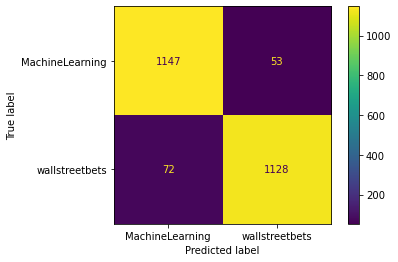

In [26]:
plot_confusion_matrix(gs,X_test,y_test)

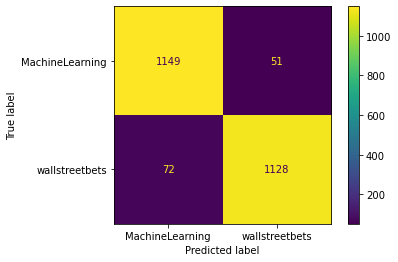

In [27]:
plot_confusion_matrix(pipe,X_test,y_test)

In [28]:
print(classification_report(y_test,gs.predict(X_test)))

print(classification_report(y_test,pipe.predict(X_test)))

                 precision    recall  f1-score   support

MachineLearning       0.94      0.96      0.95      1200
 wallstreetbets       0.96      0.94      0.95      1200

       accuracy                           0.95      2400
      macro avg       0.95      0.95      0.95      2400
   weighted avg       0.95      0.95      0.95      2400

                 precision    recall  f1-score   support

MachineLearning       0.94      0.96      0.95      1200
 wallstreetbets       0.96      0.94      0.95      1200

       accuracy                           0.95      2400
      macro avg       0.95      0.95      0.95      2400
   weighted avg       0.95      0.95      0.95      2400



## Multinomial NB CV

In [29]:
# pipeline with countvectorizer and naive bayes

pipe_2 = make_pipeline(CountVectorizer(stop_words='english'),MultinomialNB())

pipe_2.fit(X_train,y_train)

pipe_2.score(X_test,y_test)

0.9429166666666666

In [30]:
# score on train set

pipe_2.score(X_train,y_train)

0.9817857142857143

In [31]:
# create dataframe

cv_df = pd.DataFrame(pipe_2.named_steps['countvectorizer'].fit_transform(X_train).toarray(),columns=pipe_2.named_steps['countvectorizer'].get_feature_names())

In [32]:
# get count of top-occurring words
top_words_tf = {}
for i in cv_df.columns:
    top_words_tf[i] =  cv_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_cv = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

In [33]:
plt.figure(figsize = (10, 5))

# visualize top 10 words
most_freq_cv.nlargest(50,1)

,0,1
0,learning,599
1,machine,430
2,ai,297
3,ml,228
4,data,208
5,tesla,182
6,tsla,161
7,model,153
8,using,151
9,day,144


<Figure size 720x360 with 0 Axes>

In [34]:
print(classification_report(y_test,pipe_2.predict(X_test)))

                 precision    recall  f1-score   support

MachineLearning       0.92      0.97      0.94      1200
 wallstreetbets       0.97      0.92      0.94      1200

       accuracy                           0.94      2400
      macro avg       0.94      0.94      0.94      2400
   weighted avg       0.94      0.94      0.94      2400



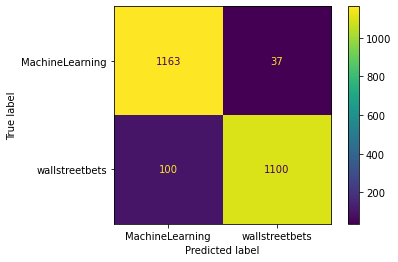

In [35]:
# plot the confusion matrix of NB

plot_confusion_matrix(pipe_2,X_test,y_test);

## SVC Tfidf

In [36]:
# SVC Pipeline

pipe_svc = make_pipeline(TfidfVectorizer(stop_words='english'),SVC(random_state=42))

In [37]:
# fit svc pipe to training data

pipe_svc.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('svc', SVC(random_state=42))])

In [38]:
# score svc pipe on train set

pipe_svc.score(X_train,y_train)

0.9985714285714286

In [39]:
# score svc pipe on test set

pipe_svc.score(X_test,y_test)

0.9570833333333333

In [40]:
params = {
    'tfidfvectorizer__max_features': range(3000,6001,500),
    'tfidfvectorizer__ngram_range':[(1,1),(1,2)],
    'tfidfvectorizer__max_df':[0.4,0.6,0.8,1.0],
    'svc__tol':[.0001,.001,.01,.1],
 
}

In [41]:
# this gridsearch takes forever even utilizing gridsearch I advise against running this cell

# params = {
#     'tfidfvectorizer__max_features': range(1000,6001,500),
#     'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)],
#     'svc__C':[1,2,3,4],
#     'svc__kernel':['linear','rbf','sigmoid'],
#     'svc__tol':[.0001,.001,.01,.1],
 
# }

In [42]:
svc_gs = GridSearchCV(pipe_svc,params,n_jobs=-1)

In [43]:
svc_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__tol': [0.0001, 0.001, 0.01, 0.1],
                         'tfidfvectorizer__max_df': [0.4, 0.6, 0.8, 1.0],
                         'tfidfvectorizer__max_features': range(3000, 6001, 500),
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]})

In [44]:
svc_gs.best_params_

{'svc__tol': 0.1,
 'tfidfvectorizer__max_df': 0.4,
 'tfidfvectorizer__max_features': 6000,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [45]:
svc_gs.score(X_train,y_train)

0.9978571428571429

In [46]:
svc_gs.score(X_test,y_test)

0.9570833333333333

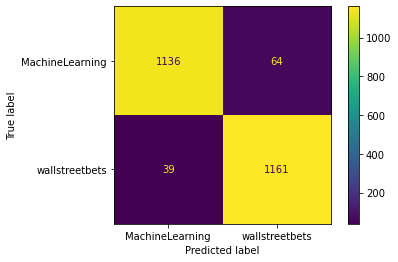

In [47]:
plot_confusion_matrix(svc_gs,X_test,y_test)

## Optimal SVC

In [48]:
# create a pipeline

svc = make_pipeline(TfidfVectorizer(max_features=6000,stop_words='english'),SVC(C=2,tol=.0001,random_state=42))

In [49]:
# fit pipeline to training set

svc.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=6000, stop_words='english')),
                ('svc', SVC(C=2, random_state=42, tol=0.0001))])

In [50]:
# score svc on train set

svc.score(X_train,y_train)

0.9985714285714286

In [51]:
# score svc on test set

svc.score(X_test,y_test)

0.9579166666666666

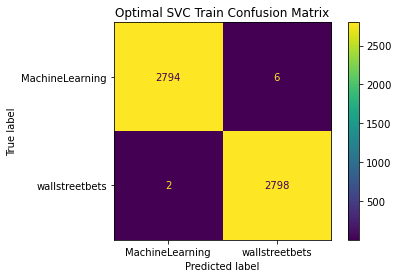

In [52]:
#plot confusion matrix of svc on train set 

plot_confusion_matrix(svc,X_train,y_train);
plt.title("Optimal SVC Train Confusion Matrix");

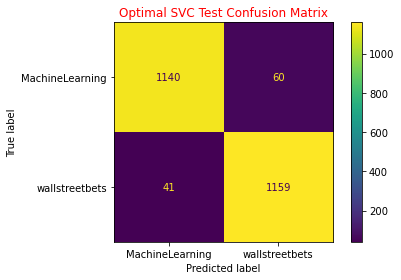

In [53]:
# plot confusion matrix of svc on test set

plot_confusion_matrix(svc,X_test,y_test,)
plt.title("Optimal SVC Test Confusion Matrix",color='red');
plt.tight_layout();
plt.savefig('imgs/ConfusionMatrix2');

I am satisfied with my model's performance based on this confusion matrix. It doesn't seem to be misclassifying once class significantly more than the other.

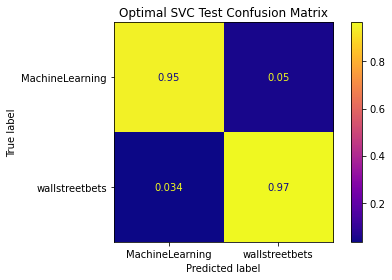

In [54]:
plot_confusion_matrix(svc,X_test,y_test,cmap='plasma',normalize='true')
plt.title("Optimal SVC Test Confusion Matrix");
plt.tight_layout();
plt.savefig('imgs/ConfusionMatrix');

In [55]:
# classification report on training set
print(classification_report(y_train,svc.predict(X_train)))

                 precision    recall  f1-score   support

MachineLearning       1.00      1.00      1.00      2800
 wallstreetbets       1.00      1.00      1.00      2800

       accuracy                           1.00      5600
      macro avg       1.00      1.00      1.00      5600
   weighted avg       1.00      1.00      1.00      5600



Classification report supports that the model is performing well.

In [56]:
# classification report on testing set
print(classification_report(y_test,svc.predict(X_test)))


                 precision    recall  f1-score   support

MachineLearning       0.97      0.95      0.96      1200
 wallstreetbets       0.95      0.97      0.96      1200

       accuracy                           0.96      2400
      macro avg       0.96      0.96      0.96      2400
   weighted avg       0.96      0.96      0.96      2400



In [57]:
# pull out idf weights

svc.named_steps['tfidfvectorizer'].idf_

array([7.68479028, 6.41182461, 8.93755325, ..., 8.93755325, 8.93755325,
       8.93755325])

In [58]:
# create df of tfidf idf weights and index as token feature names

idf_weights = pd.DataFrame(svc.named_steps['tfidfvectorizer'].idf_,index=svc.named_steps['tfidfvectorizer'].get_feature_names(),columns=["idf_weights"])

In [59]:
# biggest weights
x = idf_weights.sort_values(by='idf_weights',ascending=True)[:10]

In [60]:
# smallest weights
y = idf_weights.sort_values(by='idf_weights',ascending=True)[-10:]

In [61]:
# combine top and bottom weights into one df
z = pd.concat([x,y])

## Optimal SVC Word Counts and Weights

High idf weight indicates Term Rarity and low idf weight indicates Term Commonality.

In [78]:
import warnings

In [76]:
warnings.filterwarnings('ignore')

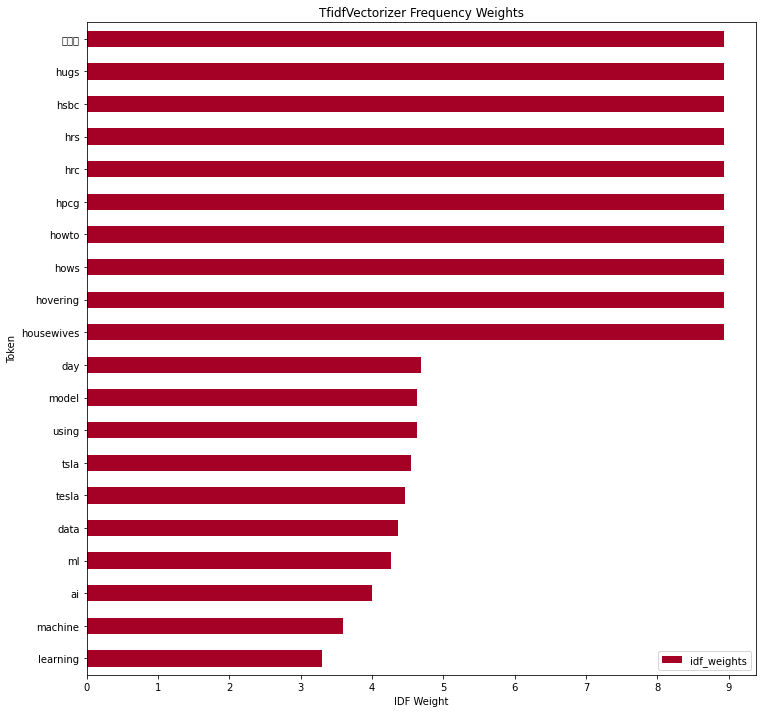

In [79]:
# plot tfidf vectorizer idf weights

z.plot(kind='barh',figsize=(12,12),colormap='RdYlGn')
plt.title('TfidfVectorizer Frequency Weights')
plt.ylabel('Token')
plt.xlabel('IDF Weight')
plt.xticks(ticks=list(range(10)));

In [80]:
# create df with

df_svc = pd.DataFrame(svc.named_steps['tfidfvectorizer'].fit_transform(X_train).toarray(),columns=svc.named_steps['tfidfvectorizer'].get_feature_names())

In [81]:
# save top 20 words as df

top_words =df_svc.sum().sort_values(ascending=False)[:20]

My top 10 most frequent words is very similar to the 10 most common words determined by idf weight. Inverse Document Frequency is determined by taking the Term Frequency and multiplying it by the Logarithm of Total posts/total # of word occurrences.

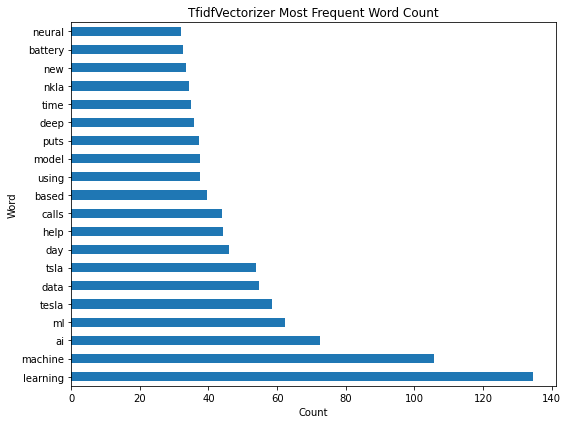

In [65]:
# plot most frequent words

top_words.plot(kind='barh',figsize=(8,6))
plt.title("TfidfVectorizer Most Frequent Word Count")
plt.ylabel('Word')
plt.xlabel('Count')
plt.tight_layout();
plt.savefig('imgs/wordcount')

In [66]:
least_words =df_svc.sum().sort_values(ascending=True)[:15]

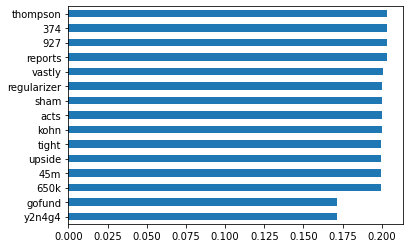

In [67]:
least_words.plot(kind='barh');


In [68]:
# get count of top-occurring words
top_words_svc = {}
for i in df_svc.columns:
    top_words_svc[i] =  df_svc[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_svc = pd.DataFrame(sorted(top_words_svc.items(), key = lambda x: x[1], reverse = True))

In [69]:
most_freq_svc.nlargest(20,1)

,0,1
0,learning,134.505887
1,machine,105.743681
2,ai,72.373932
3,ml,62.157488
4,tesla,58.575775
5,data,54.821778
6,tsla,53.828627
7,day,45.998074
8,help,44.341484
9,calls,43.851056


In [70]:
preds = svc.predict(X_test)
preds

array(['wallstreetbets', 'MachineLearning', 'wallstreetbets', ...,
       'wallstreetbets', 'MachineLearning', 'wallstreetbets'],
      dtype=object)

In [71]:
svc.predict(['I hope apple becomes compatible with a gpu. '])

array(['wallstreetbets'], dtype=object)

In [72]:
svc.predict(['I just generated a computer vision model to classify images.'])

array(['MachineLearning'], dtype=object)

In [73]:
svc.predict(['Apple better release a computer that is compatible with gpus'])

array(['MachineLearning'], dtype=object)

## Pickle

Import pickle to save the best svc model to be used later in my streamlit app. 

In [74]:
import pickle
# now you can save it to a file
with open('tweet.pkl', 'wb') as f:
    pickle.dump(svc, f)

